### --- INSTALLATION ---

In [ ]:
# %pip install -r requirements.txt

### Pretraining

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from models import MAE_ViT_Project

# DATA SETUP
BATCH_SIZE = 64
IMG_SIZE = 224  # ViT Dimensions

# Transform pipeline with Resize!
transform_pipeline = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Downloading STL-10...")
# STL-10 Unlabeled for MAE
dataset_ssl = torchvision.datasets.STL10(root='./data', split="unlabeled", download=True, transform=transform_pipeline)
loader_ssl = DataLoader(dataset_ssl, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

def patchify(imgs, patch_size):
    """
    imgs: (N, 3, H, W)
    x: (N, L, patch_size**2 *3)
    """
    p = patch_size
    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0
    
    h = w = imgs.shape[2] // p
    x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
    return x

# TRAIN MAE
print("Initializing MAE Model...")
model = MAE_ViT_Project(vit_arch='vit_base_patch16_224', mask_ratio=0.75).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1.5e-4, betas=(0.9, 0.95), weight_decay=0.05)
# criterion = torch.nn.MSELoss()
criterion = torch.nn.L1Loss() # Does not penalize outliers as much as mse loss (better edges)

epoch_losses = []

print("Starting Training...")
model.train()
for epoch in range(50): # Adjust epochs as needed
    total_loss = 0
    for batch_idx, (imgs, _) in enumerate(loader_ssl):
        imgs = imgs.to(device)
        
        # Forward Pass
        pred, mask = model(imgs)
        
        # Calculate Target (Patchified Images)
        target = patchify(imgs, model.patch_size)
        
        # Calculate Loss (Only on masked patches should be used, but L1 loss on all is fine for simplicity)
        # Ideally: loss = (pred - target) ** 2; loss = loss.mean(dim=-1); loss = (loss * mask).sum() / mask.sum()
        # Simple ver: (Mask not used, simple)
        loss = criterion(pred, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 50 == 0:
            print(f"Epoch {epoch} [{batch_idx}/{len(loader_ssl)}] Loss: {loss.item():.4f}")

    print(f"==> Epoch {epoch} Finished. Avg Loss: {total_loss / len(loader_ssl):.4f}")
    epoch_losses.append(total_loss / len(loader_ssl))

# Save the encoder
torch.save(model.get_encoder().state_dict(), "mae_encoder_final.pth")
print("Saved Pre-trained Encoder!")

/home/neurolab/Desktop/Visual-Understanding/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using Device: cuda
Initializing MAE Model...
Starting Training...
Epoch 0 [0/1563] Loss: 1.1978
Epoch 0 [50/1563] Loss: 0.7223
Epoch 0 [100/1563] Loss: 0.6911
Epoch 0 [150/1563] Loss: 0.6476
Epoch 0 [200/1563] Loss: 0.6407
Epoch 0 [250/1563] Loss: 0.6705
Epoch 0 [300/1563] Loss: 0.6227
Epoch 0 [350/1563] Loss: 0.6604
Epoch 0 [400/1563] Loss: 0.5963
Epoch 0 [450/1563] Loss: 0.5955
Epoch 0 [500/1563] Loss: 0.5657
Epoch 0 [550/1563] Loss: 0.6027
Epoch 0 [600/1563] Loss: 0.6164
Epoch 0 [650/1563] Loss: 0.5887
Epoch 0 [700/1563] Loss: 0.5978
Epoch 0 [750/1563] Loss: 0.6232
Epoch 0 [800/1563] Loss: 0.5756
Epoch 0 [850/1563] Loss: 0.5343
Epoch 0 [900/1563] Loss: 0.5752
Epoch 0 [950/1563] Loss: 0.5870
Epoch 0 [1000/1563] Loss: 0.5879
Epoch 0 [1050/1563] Loss: 0.5317
Epoch 0 [1100/1563] Loss: 0.5824
Epoch 0 [1150/1563] Loss: 0.5902
Epoch 0 [1200/1563] Loss: 0.5049
Epoch 0 [1250/1563] Loss: 0.5645
Epoch 0 [1300/1563] Loss: 0.5882
Epoch 0 [1350/1563] Loss: 0.5367
Epoch 0 [1400/1563] Loss: 0.5533


### Loss Curve

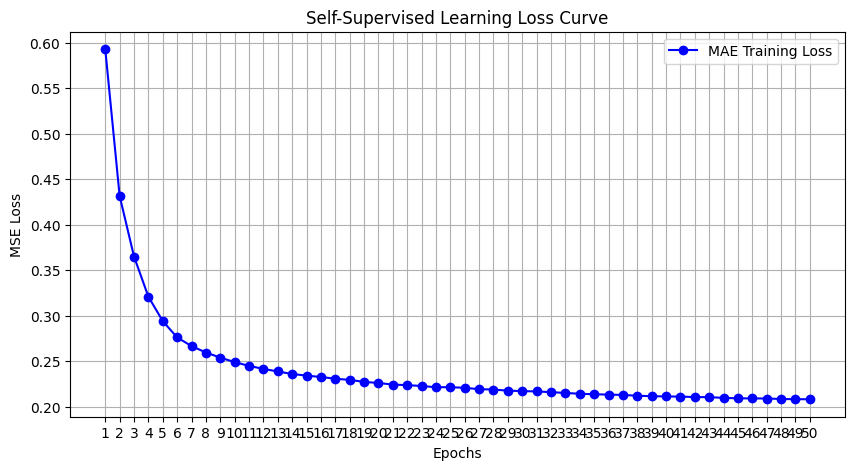

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linestyle='-', color='b', label='MAE Training Loss')
plt.title('Self-Supervised Learning Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.legend()
plt.xticks(range(1, len(epoch_losses) + 1))
plt.show()

### Model Performance
Reconstruction of the images from the training dataset

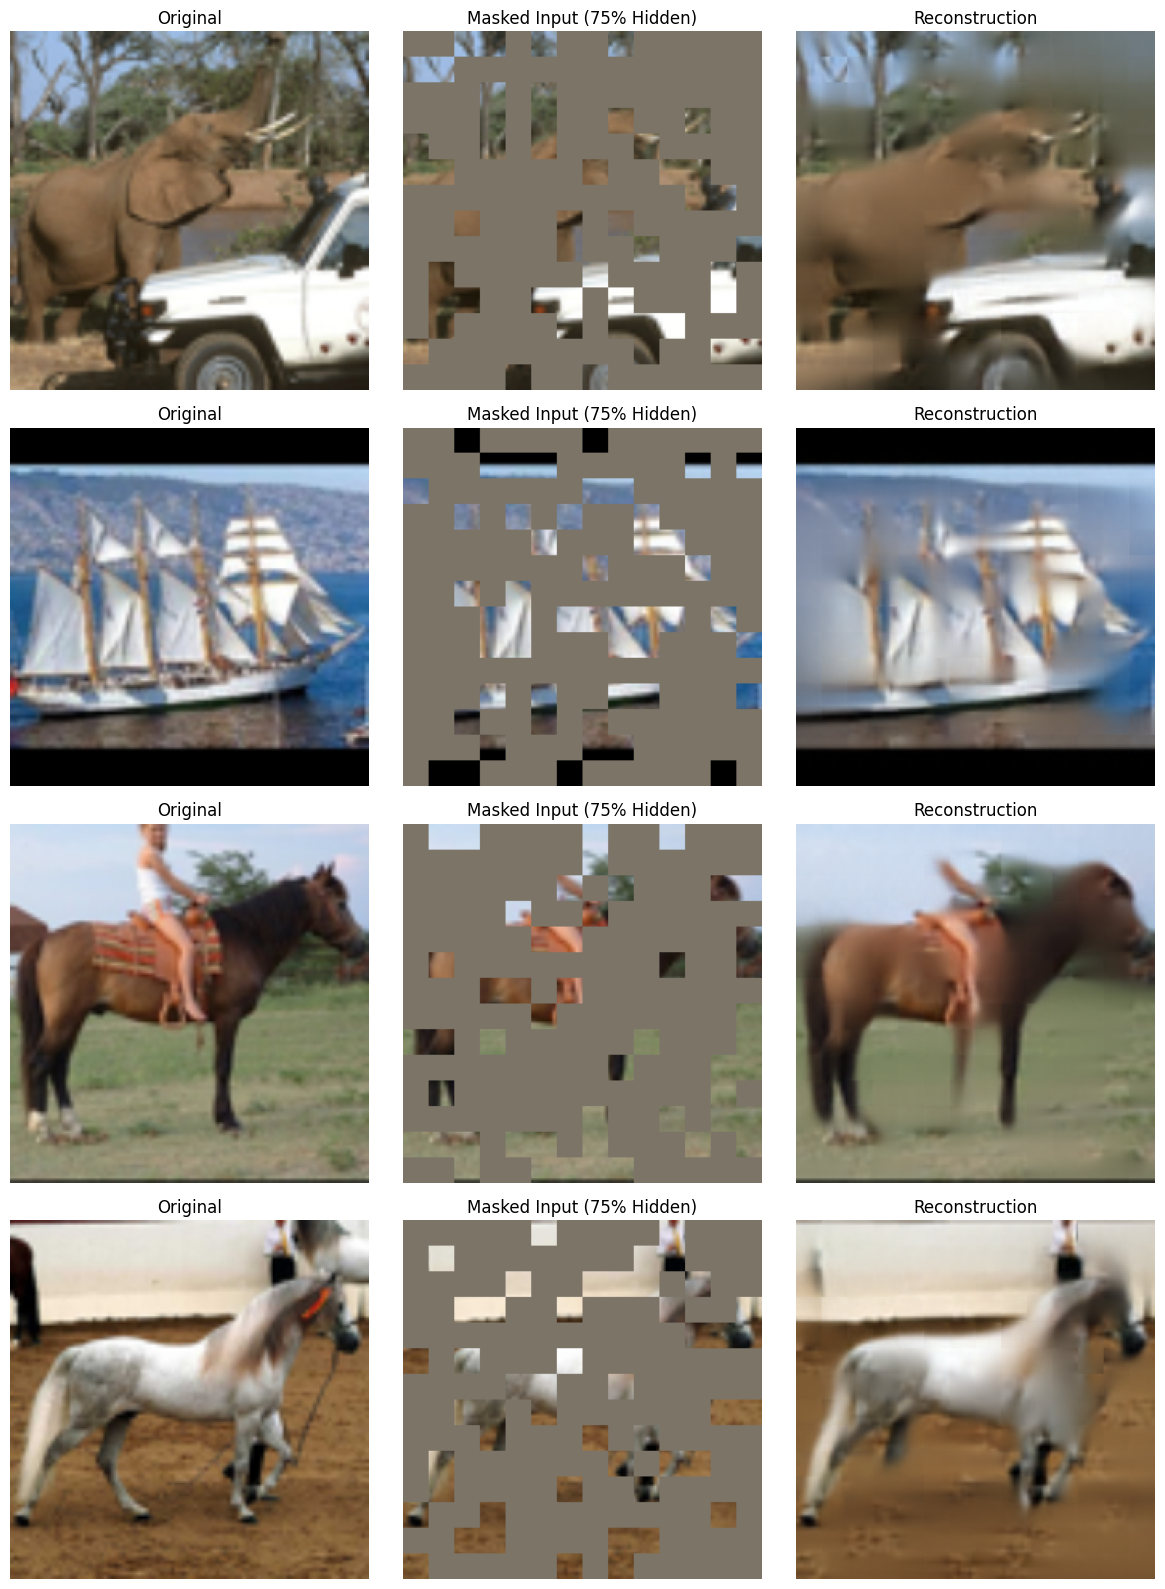

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def denormalize(img_tensor):
    """Undo the ImageNet normalization to display meaningful colors"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(img_tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(img_tensor.device)
    return img_tensor * std + mean

def unpatchify(x, patch_size):
    """
    Reconstruct image from patches.
    x: (N, L, patch_size**2 * 3) -> (N, 3, H, W)
    """
    p = patch_size
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
    return imgs

def visualize_mae(model, loader, device, num_samples=4):
    model.eval()
    
    # Get a single batch
    imgs, _ = next(iter(loader))
    imgs = imgs.to(device)
    
    with torch.no_grad():
        # Get predictions and the mask (0 = keep, 1 = remove)
        pred, mask = model(imgs)
        
        # Reconstruct the prediction
        pred_imgs = unpatchify(pred, model.patch_size)
        
        # Reconstruct the Masked Image (for visualization)
        # We apply the mask to the original patches to show "what the model saw"
        # Mask is (N, L), expand to (N, L, D)
        mask_expanded = mask.unsqueeze(-1).repeat(1, 1, pred.shape[-1])
        
        # In MAE, we only show the VISIBLE patches. 
        # But to plot it as an image, we can just gray out the masked parts.
        # Patchify original image -> Apply Mask -> Unpatchify
        from __main__ import patchify
        original_patches = patchify(imgs, model.patch_size)
        
        # Zero out the masked patches (set to 0 or gray)
        im_masked_patches = original_patches * (1 - mask_expanded)
        im_masked = unpatchify(im_masked_patches, model.patch_size)

    # Plotting
    fig, axs = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
    
    for i in range(num_samples):
        # Original
        orig = denormalize(imgs[i]).cpu().permute(1, 2, 0).numpy()
        orig = np.clip(orig, 0, 1)
        
        # Masked Input (What the model saw)
        masked = denormalize(im_masked[i]).cpu().permute(1, 2, 0).numpy()
        masked = np.clip(masked, 0, 1)
        
        # Reconstruction (The model's dream)
        recon = denormalize(pred_imgs[i]).cpu().permute(1, 2, 0).numpy()
        recon = np.clip(recon, 0, 1)
        
        axs[i, 0].imshow(orig)
        axs[i, 0].set_title("Original")
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(masked)
        axs[i, 1].set_title("Masked Input (75% Hidden)")
        axs[i, 1].axis('off')
        
        axs[i, 2].imshow(recon)
        axs[i, 2].set_title("Reconstruction")
        axs[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_mae(model, loader_ssl, device)